In [ ]:
import os
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# **I. Thiết lập cấu hình**


In [ ]:
FILE_PATH = "/content/drive/MyDrive/Dữ liệu/BK_20_Test_3_clean.csv"
TIMESTEPS = 120          # lookback
SAVGOL_WINDOW = 11
SAVGOL_POLY = 2
TEST_RATIO = 0.2
RANDOM_SEED = 42
BATCH_SIZE = 32
EPOCHS = 100
MODEL_OUT = "best_dual_bilstm_shap.keras"

In [ ]:
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [ ]:
df = pd.read_csv(FILE_PATH)
print("Loaded shape:", df.shape)
print(df.head().to_string(index=False))

Loaded shape: (1693, 19)
      Date  Buffer pressure min  Buffer pressure max  Annulus pressure min  Annulus pressure max  Flow pressure min  Flow pressure max  T min  T max       Qliq       Qoil  Water cut  Qgas  Choke  Gas factor  Gas injection rate  Downtime  Potential oil production  Potential liquid production
2020-10-03                 32.2                 45.8                  83.2                  83.9               15.0               18.7     21     33  90.999984  54.777778       39.8 20679     10         466               14.96      0.00                     44.37                         91.0
2020-10-06                 15.1                 41.2                  77.9                  82.0               15.0               20.5     33     55 100.479152  55.154706       45.1 31831     22         675                0.42      1.25                     47.14                        106.0
2020-10-24                 47.7                 52.4                  89.5                  91.2   

# **II. Tiền xử lý dữ liệu**

In [ ]:
# Tạo giá trị trung bình

pairs = [
    ('Annulus pressure', 'Annulus pressure min', 'Annulus pressure max'),
    ('Buffer pressure', 'Buffer pressure min', 'Buffer pressure max'),
    ('Flow pressure', 'Flow pressure min', 'Flow pressure max'),
    ('T', 'T min', 'T max')
]
for name, col_min, col_max in pairs:
    if col_min in df.columns and col_max in df.columns:
        df[f'{name}_avg'] = (df[col_min] + df[col_max]) / 2

XỬ LÝ OUTLINER

In [ ]:
df['Qliq_smooth'] = df['Qliq'].ewm(span=11).mean()


Làm mượt dữ liệu, Tốc độ thay đổi, trung bình động

In [ ]:
# Tốc độ thay đổi

df['dQliq'] = df['Qliq_smooth'].diff().fillna(0)
if 'Gas injection rate' in df.columns:
    df['dGI'] = df['Gas injection rate'].diff().fillna(0)
if 'Flow pressure_avg' in df.columns:
    df['dFlowP'] = df['Flow pressure_avg'].diff().fillna(0)

In [ ]:
# Trung bình động

df['Qliq_ma7'] = df['Qliq_smooth'].rolling(7, min_periods=1).mean()
df['Qliq_ma21'] = df['Qliq_smooth'].rolling(21, min_periods=1).mean()

In [ ]:
# Phát hiện sự kiện Shut-in/ Restart

df['drop_pct_3'] = df['Qliq_smooth'].pct_change(3).fillna(0)
df['event_shutin'] = (df['drop_pct_3'] < -0.40).astype(int)  # threshold: drop >40% in 3 steps
df['event_restart'] = ((df['drop_pct_3'] > 0.40) & (df['Qliq_smooth'] < df['Qliq_ma7'])).astype(int)

#**III. LỰA CHỌN ĐẶC TRƯNG ĐẦU VÀO**

In [ ]:
# Đầu mào mô hình LSTM

static_features = [
    'Annulus pressure_avg', 'T_avg',
    'Gas injection rate', 'Choke', 'Downtime',
    'Qliq_smooth','dQliq','dGI','dFlowP','Qliq_ma7','Qliq_ma21'
]
feature_seq = static_features

In [ ]:
print(feature_seq)

['Annulus pressure_avg', 'T_avg', 'Gas injection rate', 'Choke', 'Downtime', 'Qliq_smooth', 'dQliq', 'dGI', 'dFlowP', 'Qliq_ma7', 'Qliq_ma21']


Định ngĩa nhánh thông tin bổ trợ

In [ ]:
# Đầu vào tĩnh tại thời điểm t

feature_dense = []
TARGET = 'Qliq'

In [ ]:
# Loại bỏ NaN trong bất kì cột quan trọng nào

needed = feature_seq + feature_dense + [TARGET]
df_clean = df.dropna(subset=needed).reset_index(drop=True)
print("After dropna:", df_clean.shape)

After dropna: (1693, 32)


# **IV. Tạo chuỗi dữ liệu**


In [ ]:
def create_sequences(df_, seq_features, dense_features, target, timesteps):
     X_seq, X_dense, Y = [], [], []
     for i in range(timesteps, len(df_)):
         X_seq.append(df_.loc[i-timesteps:i-1, seq_features].values)  # shape (timesteps, n_features)
         X_dense.append(df_.loc[i, dense_features].values if dense_features else np.array([]))
         Y.append(df_.loc[i, target])
     X_seq = np.array(X_seq)
     X_dense = np.array(X_dense) if len(dense_features)>0 else None
     Y = np.array(Y).reshape(-1,1)
     return X_seq, X_dense, Y

In [ ]:
X_seq_all, X_dense_all, Y_all = create_sequences(df_clean, feature_seq, feature_dense, TARGET, TIMESTEPS)
print("Shapes:", X_seq_all.shape, (X_dense_all.shape if X_dense_all is not None else None), Y_all.shape)

Shapes: (1573, 120, 11) None (1573, 1)


#**V. Chia Train/Test (ttheo thời gian)**

In [ ]:
n_total = X_seq_all.shape[0]
n_test = int(n_total * TEST_RATIO)
n_train = n_total - n_test

In [ ]:
X_seq_train = X_seq_all[:n_train]
X_seq_test  = X_seq_all[n_train:]
Y_train = Y_all[:n_train]
Y_test  = Y_all[n_train:]

In [ ]:
if X_dense_all is not None:
    X_dense_train = X_dense_all[:n_train]
    X_dense_test  = X_dense_all[n_train:]
else:
    X_dense_train = None
    X_dense_test = None

In [ ]:
# Lưu trữ lại Water cut và Qoil thực tế của tập Test để vẽ biểu đồ sau này

align_idx = df_clean.index[TIMESTEPS + n_train : TIMESTEPS + n_train + n_test]
watercut_test = df_clean.loc[align_idx,'Water cut'].values.reshape(-1,1) if 'Water cut' in df_clean.columns else None
qoil_test = df_clean.loc[align_idx,'Qoil'].values.reshape(-1,1) if 'Qoil' in df_clean.columns else None

#**VI. Chuẩn hóa**


In [ ]:
# Chuẩn hóa riêng từng cột đặc trưng bằng cách làm phẳng tập train theo thời gian

n_features = X_seq_train.shape[2]
scalers_seq = []

for i in range(n_features):
    s = MinMaxScaler()
    col = X_seq_train[:,:,i].reshape(-1,1)
    s.fit(col)
    scalers_seq.append(s)

def scale_X_seq(X):
    Xs = np.empty_like(X, dtype=float)
    for i in range(X.shape[2]):
        flat = X[:,:,i].reshape(-1,1)
        flat_s = scalers_seq[i].transform(flat)
        Xs[:,:,i] = flat_s.reshape(X.shape[0], X.shape[1])
    return Xs

In [ ]:
scaler_y = MinMaxScaler()
scaler_y.fit(Y_train)

MinMaxScaler()

In [ ]:
X_seq_train_s = scale_X_seq(X_seq_train)
X_seq_test_s = scale_X_seq(X_seq_test)
Y_train_s = scaler_y.transform(Y_train)
Y_test_s = scaler_y.transform(Y_test)

In [ ]:
if X_dense_train is not None:
    scaler_dense = MinMaxScaler()
    scaler_dense.fit(X_dense_train)
    X_dense_train_s = scaler_dense.transform(X_dense_train)
    X_dense_test_s  = scaler_dense.transform(X_dense_test)
else:
    X_dense_train_s = None
    X_dense_test_s = None

#**VII. Build Dual-Input model (Xây dựng 2 đầu vào mô hình) - Khởi tạo model**

In [ ]:
# Định nghĩa lớp Attention (Bắt buộc phải có trước khi build model)

class AttentionLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1]), initializer='glorot_uniform', trainable=True)  # W: Trọng số để học sự tương quan giữa các bước thời gian
        self.b = self.add_weight(shape=(input_shape[-1],), initializer='zeros', trainable=True)                           # b: Bias
        self.u = self.add_weight(shape=(input_shape[-1],1), initializer='glorot_uniform', trainable=True)                 # u: Vector ngữ cảnh
        super(AttentionLayer, self).build(input_shape)
    def call(self, inputs):
        # inputs: (batch, timesteps, units)
        # Tính điểm số (score)
        v = tf.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)   # (batch, t, units)
        vu = tf.tensordot(v, self.u, axes=1)  # (batch, t, 1)
        # Tính trọng số attention (alphas)
        alphas = tf.nn.softmax(vu, axis=1)    # (batch, t, 1)
        # Tổng hợp context vector
        output = tf.reduce_sum(inputs * alphas, axis=1)  # (batch, units)
        return output

In [ ]:
# Nhánh Sequence (Bi-LSTM + attention)

seq_input = Input(shape=(TIMESTEPS, n_features), name='seq_input')
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(seq_input)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Dropout(0.2)(x)

att = AttentionLayer()(x)   # shape (batch, units)
att = layers.Dense(64, activation='relu')(att)

In [ ]:
# nhánh dense (các đặc trưng tĩnh tại thời điểm hiện tại)

if X_dense_train_s is not None:
    dense_input = Input(shape=(X_dense_train_s.shape[1],), name='dense_input')
    d = layers.Dense(32, activation='relu')(dense_input)
    d = layers.Dropout(0.15)(d)
    merged = layers.Concatenate()([att, d])
    inputs = [seq_input, dense_input]
else:
    merged = att
    inputs = [seq_input]

In [ ]:
# Head output

h = layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(merged)
h = layers.Dropout(0.15)(h)
h = layers.Dense(32, activation='relu')(h)
out = layers.Dense(1, activation='linear')(h)

In [ ]:
# Khởi tạo model

model = Model(inputs=inputs, outputs=out)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse')
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ seq_input (InputLayer)          │ (None, 120, 11)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 120, 256)       │       143,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 120, 128)       │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 120, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer_1               │ (None, 128)            │        16,640 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 338,881 (1.29 MB)

 Trainable params: 338,881 (1.29 MB)

 Non-trainable params: 0 (0.00 B)

#**VIII. Huấn luyện mô hình**

In [ ]:
# Callbacks

es = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=1e-5)
mc = ModelCheckpoint(MODEL_OUT, monitor='val_loss', save_best_only=True)

In [ ]:
# Training

if X_dense_train_s is not None:
    hist = model.fit([X_seq_train_s, X_dense_train_s], Y_train_s,
                     validation_split=0.1, epochs=EPOCHS, batch_size=BATCH_SIZE,
                     callbacks=[es, rlr, mc], verbose=1)
else:
    hist = model.fit(X_seq_train_s, Y_train_s,
                     validation_split=0.1, epochs=EPOCHS, batch_size=BATCH_SIZE,
                     callbacks=[es, rlr, mc], verbose=1)

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 34s 613ms/step - loss: 0.0674 - val_loss: 0.0049 - learning_rate: 0.0010
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 39s 567ms/step - loss: 0.0121 - val_loss: 0.0040 - learning_rate: 0.0010
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 557ms/step - loss: 0.0095 - val_loss: 0.0036 - learning_rate: 0.0010
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 28s 791ms/step - loss: 0.0086 - val_loss: 0.0035 - learning_rate: 0.0010
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 32s 536ms/step - loss: 0.0081 - val_loss: 0.0040 - learning_rate: 0.0010
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 23s 604ms/step - loss: 0.0073 - val_loss: 0.0036 - learning_rate: 0.0010
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 19s 538ms/step - loss: 0.0067 - val_loss: 0.0028 - learning_rate: 0.0010
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 554ms/step - loss: 0.0066 - val_loss: 0.0025 - learning_rate: 0.0010
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 546ms/step - loss: 0.0059 - val_loss: 0.0034 - learning_rate:

#**IX. Dự báo và đánh giá kết quả**

In [ ]:
#Dự báo Qliq

if X_dense_test_s is not None:
    y_pred_s = model.predict([X_seq_test_s, X_dense_test_s])
else:
    y_pred_s = model.predict(X_seq_test_s)

y_pred = scaler_y.inverse_transform(y_pred_s)
y_test_actual = scaler_y.inverse_transform(Y_test_s)

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 221ms/step


In [ ]:
# Tính Qoil từ Qliq dự đoán

if watercut_test is not None:
    wc = watercut_test.copy()
    if np.nanmax(wc) > 1.0:
        wc = wc/100.0
    y_pred_qoil = y_pred * (1 - wc)
    y_pred_qoil[y_pred_qoil < 0] = 0
else:
    y_pred_qoil = None

In [ ]:
# Đánh giá kết quả

def rmse(a,b): return np.sqrt(mean_squared_error(a,b))
rmse_qliq = rmse(y_test_actual, y_pred)
r2_qliq = r2_score(y_test_actual, y_pred)
print("Qliq RMSE:", rmse_qliq, "R2:", r2_qliq)

if qoil_test is not None and y_pred_qoil is not None:
    rmse_qoil = rmse(qoil_test, y_pred_qoil)
    r2_qoil = r2_score(qoil_test, y_pred_qoil)
    print("Qoil RMSE:", rmse_qoil, "R2:", r2_qoil)

Qliq RMSE: 8.57770492015274 R2: 0.5750598354244367
Qoil RMSE: 2.454448673360958 R2: 0.8414335542559486


# **X. Trực quan hóa**

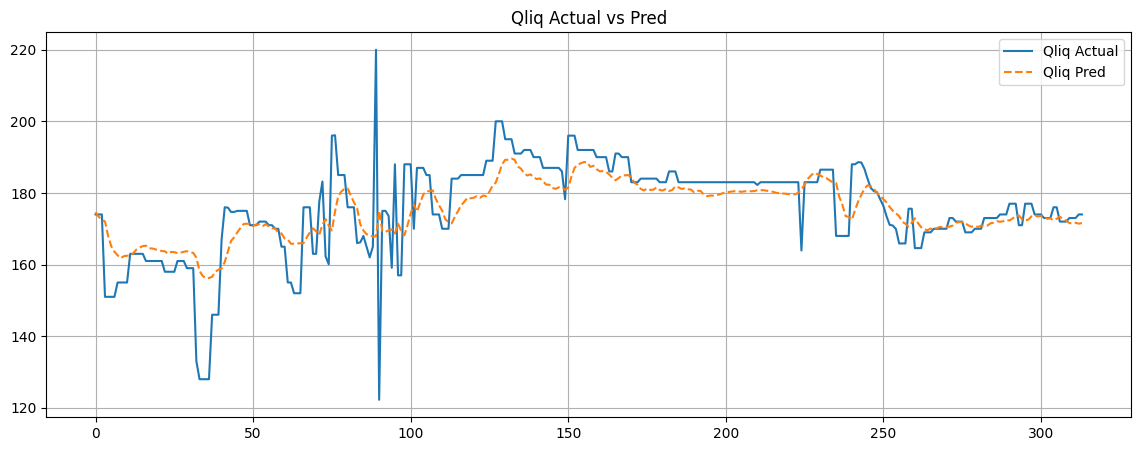

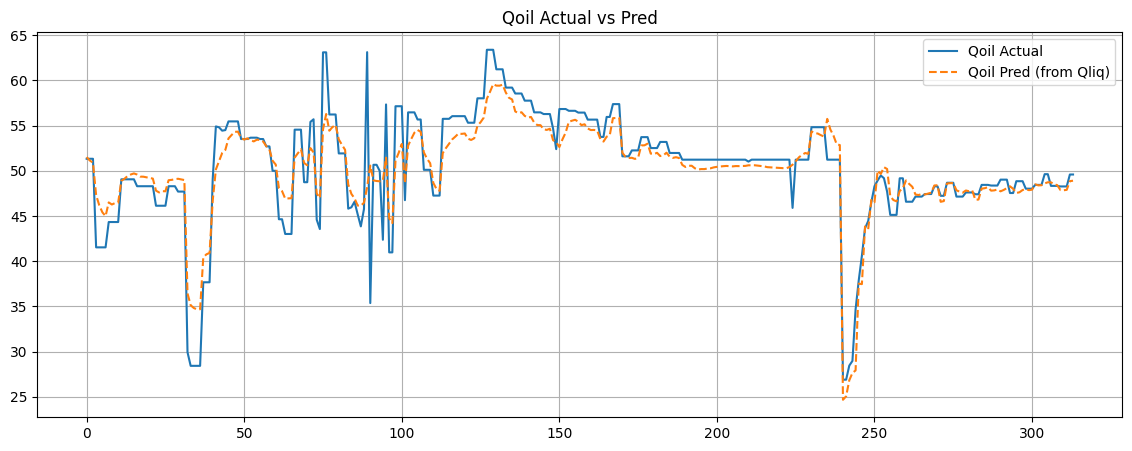

In [ ]:
plt.figure(figsize=(14,5))
plt.plot(y_test_actual, label='Qliq Actual')
plt.plot(y_pred, linestyle='--', label='Qliq Pred')
plt.title('Qliq Actual vs Pred')
plt.legend(); plt.grid(True); plt.show()

if y_pred_qoil is not None:
    plt.figure(figsize=(14,5))
    plt.plot(qoil_test, label='Qoil Actual')
    plt.plot(y_pred_qoil, linestyle='--', label='Qoil Pred (from Qliq)')
    plt.title('Qoil Actual vs Pred')
    plt.legend(); plt.grid(True); plt.show()

In [ ]:
#import tensorflow as tf
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense

#model.save('/content/drive/MyDrive/best_dual_bilstm_attention.keras')


RMSE Ban đầu: 0.05308


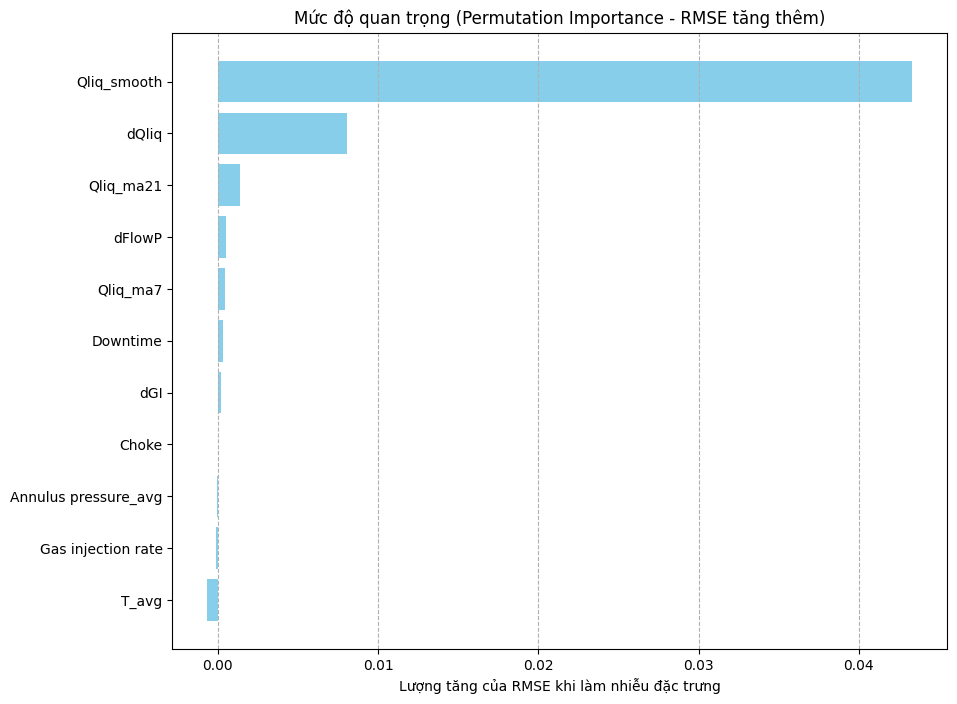

In [ ]:
from sklearn.metrics import mean_squared_error

def get_score(model, X_seq, X_dense, Y_true):
    """Hàm tính RMSE hiện tại"""
    if X_dense is not None:
        pred = model.predict([X_seq, X_dense], verbose=0)
    else:
        pred = model.predict(X_seq, verbose=0)
    return np.sqrt(mean_squared_error(Y_true, pred))

# 1. Tính lỗi ban đầu (Baseline)
# Dùng 200 mẫu test để chạy cho nhanh
n_samples = 200
X_seq_sub = X_seq_test_s[:n_samples]
X_dense_sub = X_dense_test_s[:n_samples] if X_dense_test_s is not None else None
Y_sub = Y_test_s[:n_samples]

baseline_rmse = get_score(model, X_seq_sub, X_dense_sub, Y_sub)
print(f"RMSE Ban đầu: {baseline_rmse:.5f}")

importances = {}

# 2. Đánh giá đặc trưng chuỗi (Sequence Features)
for i, col_name in enumerate(feature_seq):
    save_col = X_seq_sub[:, :, i].copy() # Lưu lại cột gốc

    # Xáo trộn cột i (trên trục mẫu)
    np.random.shuffle(X_seq_sub[:, :, i])

    # Tính lỗi mới
    new_rmse = get_score(model, X_seq_sub, X_dense_sub, Y_sub)
    importances[col_name] = new_rmse - baseline_rmse # Độ tăng lỗi

    # Trả lại cột gốc
    X_seq_sub[:, :, i] = save_col

# 3. Đánh giá đặc trưng tĩnh (Dense Features) - nếu có
if X_dense_sub is not None:
    feature_dense_names = feature_dense if 'feature_dense' in locals() else [f"Dense_{i}" for i in range(X_dense_sub.shape[1])]
    for i, col_name in enumerate(feature_dense_names):
        save_col = X_dense_sub[:, i].copy()

        np.random.shuffle(X_dense_sub[:, i])

        new_rmse = get_score(model, X_seq_sub, X_dense_sub, Y_sub)
        importances[col_name] = new_rmse - baseline_rmse

        X_dense_sub[:, i] = save_col

# 4. Vẽ biểu đồ xếp hạng
# Sắp xếp giảm dần
sorted_feats = sorted(importances.items(), key=lambda x: x[1], reverse=False) # sort for barh
names = [x[0] for x in sorted_feats]
values = [x[1] for x in sorted_feats]

plt.figure(figsize=(10, 8))
plt.barh(names, values, color='skyblue')
plt.title("Mức độ quan trọng (Permutation Importance - RMSE tăng thêm)")
plt.xlabel("Lượng tăng của RMSE khi làm nhiễu đặc trưng")
plt.grid(axis='x', linestyle='--')
plt.show()